In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import spacy
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer


# Load spaCy model (run !python -m spacy download en_core_web_sm if not already)
nlp = spacy.load("en_core_web_sm")

In [8]:
def load_and_clean(file_path):
    print("🔄 Loading data...")
    df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')  # <-- Fix here
    print(f"✅ Loaded {len(df)} rows.")
    ...
    return df


In [9]:
def headline_stats(df, sample_size=10000):
    print("\n🧠 Headline Word Count Stats (sampled):")
    sample = df['headline'].dropna().sample(min(sample_size, len(df)), random_state=42)
    sample_lengths = sample.apply(lambda x: len(str(x).split()))
    print(sample_lengths.describe())

    print("\n📰 Top 5 Publishers:")
    print(df['publisher'].value_counts().head())

In [10]:
def run_topic_modeling(df, n_topics=5, n_top_words=10, sample_size=10000):
    print("\n🧪 Running optimized topic modeling (sampled)...")
    sample = df['headline'].dropna().sample(min(sample_size, len(df)), random_state=42)

    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(sample.astype(str))

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='batch', random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    topics = {f"Topic {idx+1}": [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
              for idx, topic in enumerate(lda.components_)}
    return topics

In [11]:
def analyze_time(df):
    if 'published_date' not in df.columns:
        print("⚠️ No time column found.")
        return None

    df['hour'] = df['published_date'].dt.hour
    df['day'] = df['published_date'].dt.day_name()

    print("\n🕒 Top publishing hours:")
    print(df['hour'].value_counts().head())

    print("\n📅 Articles by Day of Week:")
    print(df['day'].value_counts())

In [12]:
def extract_named_entities(df, n=300):
    print("\n🧠 Extracting named entities (ORG, PERSON) on sample...")
    sample_texts = df['headline'].dropna().sample(min(n, len(df)), random_state=42)
    entities = {'ORG': [], 'PERSON': []}

    for doc in nlp.pipe(sample_texts, disable=["parser", "tagger"]):
        for ent in doc.ents:
            if ent.label_ in entities:
                entities[ent.label_].append(ent.text)

    return {k: Counter(v).most_common(10) for k, v in entities.items()}

In [ ]:
def run_analysis(file_path):
    start_time = time.time()

    df = load_and_clean(file_path)
    headline_stats(df)
    analyze_time(df)

    topics = run_topic_modeling(df)
    print("\n🔍 Topics Discovered:")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")

    ents = extract_named_entities(df)
    print("\n🏷️ Named Entities (Top 10):")
    for ent_type, items in ents.items():
        print(f"{ent_type}: {[ent for ent, _ in items]}")

    print(f"\n✅ Analysis completed in {time.time() - start_time:.2f} seconds.")
    return df, topics, ents

In [17]:
file_path = r"C:\Users\HP\Downloads\raw_analyst_ratings.csv\raw_analyst_ratings.csv"
df, topics, ents = run_analysis(file_path)
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
if 'published_date' in df.columns:
    df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

df['date'] = df['published_date'].dt.date
df['date'].value_counts().sort_index().plot(kind='line', figsize=(12, 4), title="Articles per Day")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.show()
df['hour'] = df['published_date'].dt.hour
df['hour'].value_counts().sort_index().plot(kind='bar', title="Articles by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()
top_publishers = df['publisher'].value_counts().head(3).index
for pub in top_publishers:
    pub_df = df[df['publisher'] == pub]
    print(f"\n📢 Topics for Publisher: {pub}")
    pub_topics = run_topic_modeling(pub_df, n_topics=3)
    for topic, words in pub_topics.items():
        print(f"{topic}: {', '.join(words)}")





🔄 Loading data...
✅ Loaded 1407328 rows.

🧠 Headline Word Count Stats (sampled):
count    10000.000000
mean        11.476200
std          6.459846
min          2.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         66.000000
Name: headline, dtype: float64

📰 Top 5 Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64
⚠️ No time column found.

🧪 Running optimized topic modeling (sampled)...

🔍 Topics Discovered:
Topic 1: benzinga, market, shares, watch, update, trading, higher, morning, downgrades, upgrades
Topic 2: earnings, scheduled, estimate, sales, analyst, eps, blog, reports, beat, beats
Topic 3: vs, est, eps, stocks, session, moving, reports, pre, day, sales
Topic 4: stock, morgan, price, target, says, shares, announces, maintains, neutral, overweight
Topic 5: week, 52, pt, stocks, buy, initiates, yesterday, coverage

c:\Users\HP\miniconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



🏷️ Named Entities (Top 10):
ORG: ['EPS', 'Pre-Market Session', 'Neutral', 'YoY', 'AT&T', 'Amazon', 'S&P', 'DVN', 'Lowers Price Target', 'Outperform']
PERSON: ['Raises', 'Q3 EPS', 'Q4 Adj', 'Benzinga', 'Pete Najarian Sees Unusual Options', 'Tues', 'Joe Biden', 'Biden', 'COVID-19', 'Raymond James Angelica']


KeyError: 'published_date'

🔄 Loading data...
✅ Loaded 1407328 rows.

🧠 Headline Word Count Stats (sampled):
count    10000.000000
mean        12.508500
std          8.398642
min          3.000000
25%          7.000000
50%         10.000000
75%         14.000000
max         70.000000
Name: headline_length, dtype: float64

📰 Top 5 Publishers:
publisher
www.benzinga.com    55987
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_22876\606151610.py:104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')
C:\Users\HP\AppData\Local\Temp\ipykernel_22876\606151610.py:113: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


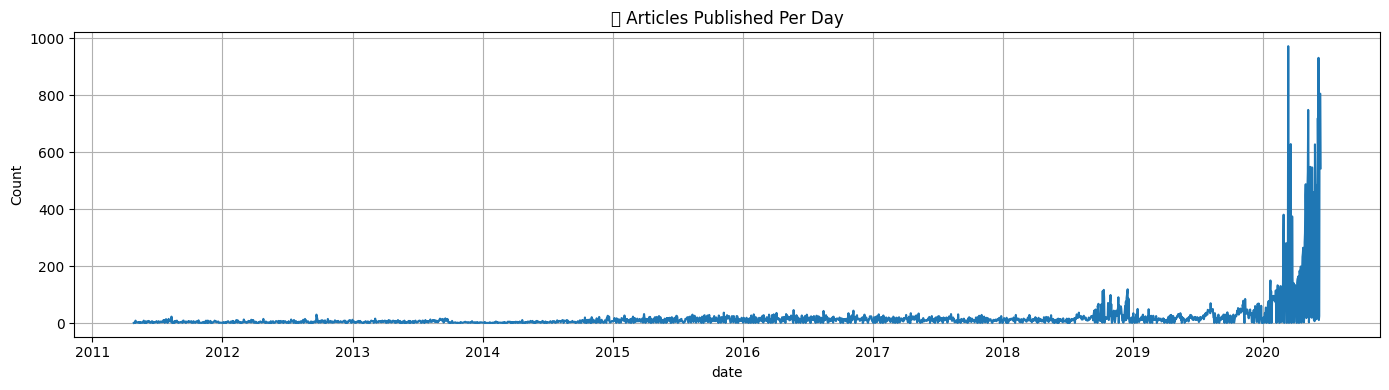

C:\Users\HP\AppData\Local\Temp\ipykernel_22876\606151610.py:124: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


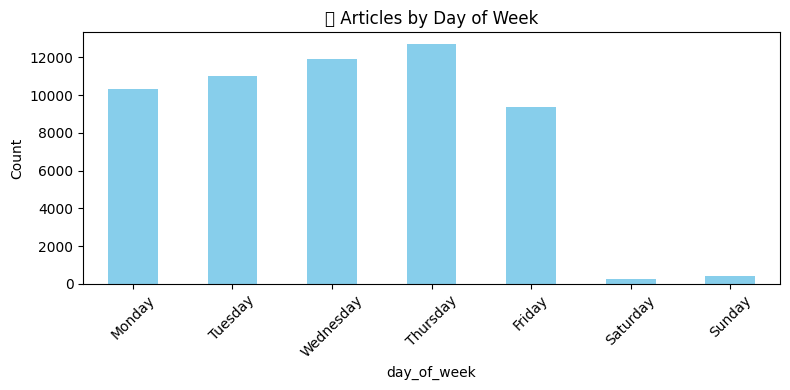

C:\Users\HP\AppData\Local\Temp\ipykernel_22876\606151610.py:133: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


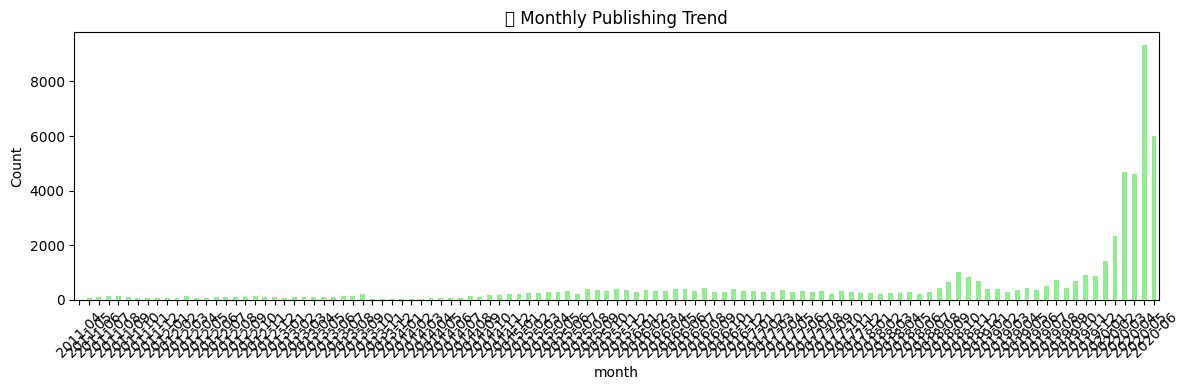


🧪 Running optimized topic modeling (sampled)...
Topic 1: stocks, 52, week, hit, lows, thursday, highs, friday, session, moving
Topic 2: shares, trading, companies, movers, biggest, higher, market, amid, following, lower
Topic 3: target, price, maintains, downgrades, eps, raises, buy, lowers, upgrades, sales
Topic 4: etfs, estimate, eps, etf, yoy, sales, q1, halted, news, announces
Topic 5: earnings, scheduled, 2020, benzinga, etfs, movers, watch, etf, q1, biggest

🧠 Extracting named entities (ORG, PERSON) on sample...


c:\Users\HP\miniconda3\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


ORG: ['EPS', 'Raises Price Target', 'Lowers Price Target', 'Pre-Market Session', 'The Daily Biotech Pulse', 'Biggest Movers', 'Neutral', 'Fed', 'FDA', 'S&P']
PERSON: ['Benzinga', 'Chair Powell', 'Q2 EPS', 'Fitzgerald Maintains', 'B. Riley', 'Novartis Lung Cancer Drug', 'Stifel Maintains Buy', 'Tues', 'Est', 'Raymond James']

✅ Analysis completed in 13.15 seconds.


In [19]:
# -------------------------------- Setup --------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import spacy
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")


# ----------------------------- Load & Clean -----------------------------
def load_and_clean(file_path):
    print("🔄 Loading data...")
    df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
    print(f"✅ Loaded {len(df)} rows.")

    df = df.dropna(subset=['headline']).reset_index(drop=True)

    if 'url' in df.columns:
        df['publisher'] = df['url'].apply(lambda x: x.split('/')[2] if pd.notna(x) and 'http' in x else 'unknown')
    elif 'author' in df.columns:
        df['publisher'] = df['author']
    else:
        df['publisher'] = 'unknown'

    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])
    else:
        df['date'] = pd.NaT

    return df


# ------------------------- Descriptive Stats ---------------------------
def headline_stats(df, sample_size=10000):
    sample = df.sample(min(len(df), sample_size), random_state=42)
    sample['headline_length'] = sample['headline'].apply(lambda x: len(str(x).split()))

    print("\n🧠 Headline Word Count Stats (sampled):")
    print(sample['headline_length'].describe())

    print("\n📰 Top 5 Publishers:")
    print(df['publisher'].value_counts().head())


# ------------------------ Topic Modeling -------------------------------
def run_topic_modeling(df, n_topics=5, n_top_words=10, sample_size=10000):
    print("\n🧪 Running optimized topic modeling (sampled)...")
    sample_texts = df['headline'].astype(str).sample(min(sample_size, len(df)), random_state=42)

    vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
    X = vectorizer.fit_transform(sample_texts)

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='batch', random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()

    topics = {f"Topic {i+1}": [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
              for i, topic in enumerate(lda.components_)}

    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")

    return topics


# -------------------- Named Entity Recognition -------------------------
def extract_named_entities(df, sample_size=300):
    print("\n🧠 Extracting named entities (ORG, PERSON) on sample...")
    sample_texts = df['headline'].dropna().sample(min(sample_size, len(df)), random_state=42)
    entities = {'ORG': [], 'PERSON': []}

    for doc in nlp.pipe(sample_texts, disable=["parser", "tagger"]):
        for ent in doc.ents:
            if ent.label_ in entities:
                entities[ent.label_].append(ent.text)

    top_entities = {k: Counter(v).most_common(10) for k, v in entities.items()}
    for ent_type, items in top_entities.items():
        print(f"{ent_type}: {[ent for ent, _ in items]}")

    return top_entities


# --------------------- Time & Trend Analysis ---------------------------
def time_series_analysis(df):
    if 'date' not in df.columns or df['date'].isna().all():
        print("⚠️ No usable 'date' column found for time analysis.")
        return

    df['day_of_week'] = df['date'].dt.day_name()
    df['month'] = df['date'].dt.to_period('M')

    # Daily
    daily = df['date'].dt.date.value_counts().sort_index()
    plt.figure(figsize=(14, 4))
    daily.plot()
    plt.title("🗓️ Articles Published Per Day")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Day of week
    dow = df['day_of_week'].value_counts().reindex([
        "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
    ])
    dow.plot(kind='bar', figsize=(8, 4), color='skyblue')
    plt.title("📆 Articles by Day of Week")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Monthly
    monthly = df['month'].value_counts().sort_index()
    monthly.plot(kind='bar', figsize=(12, 4), color='lightgreen')
    plt.title("📅 Monthly Publishing Trend")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ----------------------------- Runner ----------------------------------
def run_analysis(file_path):
    start = time.time()

    df = load_and_clean(file_path)
    headline_stats(df)
    time_series_analysis(df)
    topics = run_topic_modeling(df)
    ents = extract_named_entities(df)

    print(f"\n✅ Analysis completed in {time.time() - start:.2f} seconds.")
    return df, topics, ents


# --------------------------- Run Here ---------------------------------
# Example: Replace with your actual path
file_path = r"C:\\Users\\HP\\Downloads\\raw_analyst_ratings.csv\\raw_analyst_ratings.csv"
df, topics, ents = run_analysis(file_path)
